In [4]:
from google-colab import drive
drive.mount('/content/drive',force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%tensorflow_version 2.9.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.9.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub

In [31]:
print(tf.__version__)

2.8.2


In [60]:
main_dir = "/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4"

categories = ["unspecified_material","bleaching_any",
              "bleaching_not",
              "bleaching_onlySome","drying_flat","drying_flat_drip","drying_flat_drip_shade","drying_flat_shade","drying_line",
              "drying_line_drip","drying_line_drip_shade","drying_line_shade","drying_tumble_lower_60","drying_tumble_normal_80","drying_tumble_not",
              "ironing_not","ironing_plate_110","ironing_plate_150","ironing_plate_200","professional_dry_mild_F","professional_dry_mild_P",
              "professional_dry_normal_F","professional_dry_normal_P","professional_dry_not","professional_wet_mild_W","professional_wet_normal_W",
              "professional_wet_not","professional_wet_veryMild_W","washing_hand_40","washing_mild_30","washing_mild_40","washing_mild_60",
              "washing_normal_30","washing_normal_40","washing_normal_60","washing_normal_95","washing_not","washing_veryMild_30","washing_veryMild_40"]


print(len(categories)) 

39


In [134]:
IMG_SIZE = 32

''' new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show() '''

" new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))\nplt.imshow(new_array, cmap='gray')\nplt.show() "

In [135]:
training_data = []

def create_training_data():
    for cat in categories:
      path = os.path.join(main_dir,cat)
      class_num = categories.index(cat)
      for img in os.listdir(path):
        #iterate over each image per class
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            print(path+"/"+img)  # convert to array
            #new_array = img_array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            training_data.append([new_array, class_num])  # add this to our training_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/0.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/1.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/3.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/4.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/5.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/6.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/7.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/8.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/10.png
/content/drive/MyDrive/oxwash/dataset2/data/individual_care_symbols/datasetv4/bleaching_not/11.png
/content/drive/MyD

In [136]:
print(len(training_data))

172


In [137]:
#random.shuffle(training_data)

2
(32, 32)


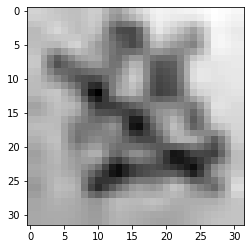

In [139]:
print(training_data[0][1])
print(training_data[0][0].shape)
#print(training_data[0][0])
plt.imshow(training_data[0][0]/255, cmap='gray')
plt.show() 

In [140]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y).astype('int').reshape(-1,1)
y = tf.keras.utils.to_categorical(y, num_classes=39)

In [141]:
print(X.shape,y.shape)
X = X/255

(172, 32, 32, 1) (172, 39)


In [142]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, train_size=0.75, random_state=42, shuffle=True, stratify=None)

In [143]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(129, 32, 32, 1)
(43, 32, 32, 1)
(129, 39)
(43, 39)


In [144]:
train_data = (X_train, y_train)
test_data = (X_test, y_test)

In [40]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
classifier_model = inception_v3

In [62]:
feature_extractor_layer = hub.KerasLayer(
    classifier_model,
    input_shape = X_train.shape[1:],
    trainable=False)

tf.keras.regularizers.L2(l2=0.5)


In [145]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

def data_augmenter():
    '''
    Create a Sequential model composed of 6 layers of preprocessing
    Returns:
    tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomFlip('vertical'))
    data_augmentation.add(tf.keras.layers.RandomRotation(factor=0.4, fill_mode="wrap"))
    data_augmentation.add(tf.keras.layers.RandomZoom(0.2,0.2))
    data_augmentation.add(tf.keras.layers.RandomContrast((0.2,0.75)))
    #data_augmentation.add(tf.keras.layers.experimental.RandomBrightness((-0.35,0.35)))
    #data_augmentation.add(tf.keras.layers.Lambda(lambda x: random_invert_img(x, 0.25)))

    return data_augmentation

data_augmentation = data_augmenter()

In [209]:
model = tf.keras.models.Sequential([
    tf.keras.Input(X_train.shape[1:]),
    #data_augmentation,

    # layer 1
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation='relu',padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    # layer 2
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    
    
    # FC Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(400, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(120, activation='relu',kernel_regularizer='l2'),
    tf.keras.layers.Dense(84, activation='relu',kernel_regularizer='l2'),
    tf.keras.layers.Dense(39, activation='softmax')
])

In [210]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 32, 32, 6)         156       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 16, 16, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 16, 16, 16)        2416      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 1024)              0         
                                                                 
 dense_78 (Dense)            (None, 400)             

In [211]:
tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

model.compile(optimizer="adam", loss = tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [212]:
history = model.fit(X_train,y_train,epochs=300,verbose=1, batch_size=16, validation_data=test_data)

Epoch 1/300
9/9 [==============================] - 1s 30ms/step - loss: 11.0514 - accuracy: 0.1395 - val_loss: 9.1246 - val_accuracy: 0.2558
Epoch 2/300
9/9 [==============================] - 0s 8ms/step - loss: 8.4563 - accuracy: 0.1938 - val_loss: 7.3326 - val_accuracy: 0.2558
Epoch 3/300
9/9 [==============================] - 0s 7ms/step - loss: 6.8053 - accuracy: 0.1550 - val_loss: 6.0891 - val_accuracy: 0.1395
Epoch 4/300
9/9 [==============================] - 0s 7ms/step - loss: 5.7123 - accuracy: 0.0930 - val_loss: 5.2549 - val_accuracy: 0.2558
Epoch 5/300
9/9 [==============================] - 0s 7ms/step - loss: 4.9517 - accuracy: 0.1938 - val_loss: 4.6999 - val_accuracy: 0.2558
Epoch 6/300
9/9 [==============================] - 0s 7ms/step - loss: 4.4881 - accuracy: 0.0853 - val_loss: 4.2895 - val_accuracy: 0.0465
Epoch 7/300
9/9 [==============================] - 0s 7ms/step - loss: 4.1170 - accuracy: 0.0698 - val_loss: 3.9873 - val_accuracy: 0.1163
Epoch 8/300
9/9 [========

In [213]:
preds = model.evaluate(X_test, y_test, batch_size=16)

3/3 [==============================] - 0s 5ms/step - loss: 3.4921 - accuracy: 0.5581


Text(0.5, 1.0, 'Loss Curves')

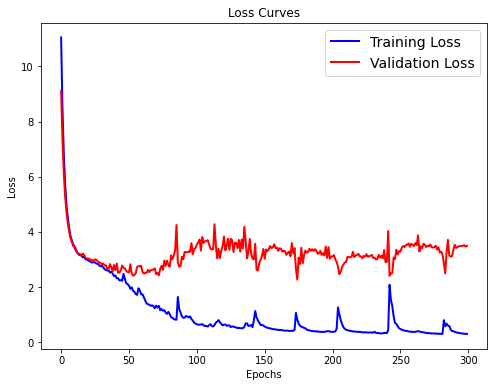

In [214]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'blue', linewidth=2.0)
plt.plot(history.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

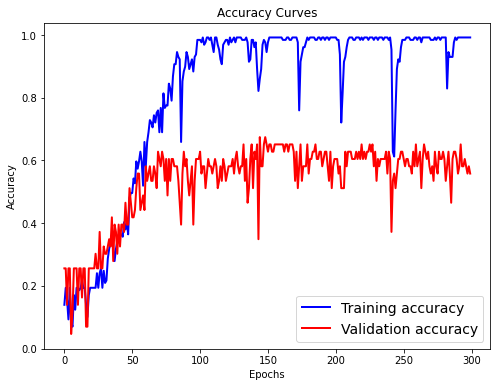

In [215]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'blue', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'red', linewidth=2.0)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)